# Mean Field Model of Cellular Growth : 2D Version

Based on work published in: A mean-field model of static recrystallization considering orientation spreads and their time-evolution: A Després, M Greenwood, CW Sinclair, Acta Materialia 199, 116-128
March 2, 2020
Chad Sinclair

In [1]:
import numpy as numpy
from scipy import math
from scipy import stats
from scipy import special
from numpy.random import random
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import pylab as pylab
import brewer2mpl
import glob 
import matplotlib.ticker as mtick


#import brewer2mpl
#colors = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

Function below provides simple progress bar to show progress of calculation

In [2]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


### Function: Generates N orientations as rodriguez vectors 
Rodriguez vectors choosen by randomly choosing lengths of the 3 basis vectors and then combining.  This gives a trivariate normal distribution centred on the reference orientation.  Function outputs the N rodriguez vectors (r) and the associated values of the disorientation angle ($\omega$) relative to the mean orientation.

In [3]:
def generate_rod(sigma_ref,N):

    len1=numpy.random.normal(0,sigma_ref, N)
    len2=numpy.random.normal(0,sigma_ref, N)
    len3=numpy.random.normal(0,sigma_ref, N)

    rod01 = numpy.asarray([1.,0.,0.])
    rod02 = numpy.asarray([0.,1.,0.])
    rod03 = numpy.asarray([0.,0.,1.])

    r = []
    rnorm = []

    for i in range(len(len1)):
        rtmp = len1[i]*rod01+len2[i]*rod02+len3[i]*rod03
        r.append(rtmp)
        rnorm.append(numpy.linalg.norm(rtmp))
    
    omega = numpy.arcsin(rnorm)
    
    return(r,omega)

### Functions: Surface energy and mobilities

Functions to calculate the surface energy (gamma) and mobility (mu) of an interface as a function of the boundary disorientation ($\theta$).  Functions to calculate the second deritivatives are also provided to allow for calculations of the average values based on Taylor series expansion.

In this case the following forms for the surface energy and mobility are used:

$\gamma = \gamma_{c}\frac{\theta}{\theta_{c}}\left(1- \ln\frac{\theta}{\theta_{c}}  \right) \hspace{3mm}$ if $\hspace{3mm} \theta \leq \theta_c \hspace{3mm}$ or $\hspace{3mm} \gamma = \gamma_c \hspace{3mm} $  if $ \hspace{3mm} \theta > \theta_c$



$\mu \left(\theta\right)=\mu_{c}\left(1- e^{-B\left(\frac{\theta}{\theta_{c}}\right)^{\eta}}  \right)$

In [4]:
# Mobility (mu) and its second derivative (muddot)
mu = lambda theta : (1-numpy.exp(-B*(theta/theta_c)**eta))
muddot = lambda theta : B*eta/theta_c**(2*eta)*numpy.exp(-B*(theta/theta_c)**eta)*(-B*eta*theta**(2*eta-2)+theta_c**eta*(eta-1)*theta**(eta-2))

# Surface energy (gamma) and its second derivative (gammaddot)
def gamma(theta):
    
    theta = numpy.asarray(theta)
    gam = theta/theta_c*(1-numpy.log(theta/theta_c)) 
    gam[theta>theta_c] = 1
    gam[theta==0] = 0
    
    return gam
        
def gammaddot(theta):
    theta = numpy.asarray(theta)
    mddot = -1/(theta_c*theta)
    mddot[theta > theta_c] = 0
    mddot[theta == 0] = 0
        
    return mddot
    
def calc_sigma_ref(r):
    
    rnorm = []
    covm = numpy.zeros([3,3])
    for i in range(len(r)):
        covm = covm + numpy.outer(r[i],r[i])
        rnorm.append(numpy.linalg.norm(r[i]))
        

    covm = covm/len(r)
    val, vect=numpy.linalg.eig(covm)
    sigma_ref = (val[0]*val[1]*val[2])**(1./6.)
    
    omega = numpy.arcsin(rnorm)
    
    return sigma_ref,omega

### Function: Main calculation for kinetics
This function takes in the set of $N$ rodriguez vectors (r), the associated grain sizes (Ri) and the number of time steps to be used (NSteps).

The function outputs 
* The mean grain radius at each time step
* The total number of grains at each time step
* The total area at each time step
* The fraction recrystallized at each time step
* The final grain size distribution
* The final distribution of the disorientaitons ($\omega$) with respect to the mean orientation

### Steps in calculation:

#### Step 1: 
* From the input rodriguez vectors the distribution of the disorientation angles and standard deviation ($\omega, \hspace{2mm} \sigma_{ref}$) are calculated. 

#### Step 2: The mean boundary angle and its variance are calculated from:

$\kappa_{\left(t,\omega\right)}=\frac{\sin{\omega/2}}{\sigma^{ref}_{\left(t,\omega\right)}}$

$<\theta>_{\left(t,\omega\right)}=\sigma^{ref}_{\left(t\right)}\sqrt{2\pi}L_{1/2}^{\left(1/2\right)}\left(-\frac{\sin{\left(\omega/2\right)^2}}{2\sigma^{ref}}\right)$

$<\theta^2>_{\left(t,\omega\right)}=4\left(\sigma^{ref}_{\left(t\right)}\right)^2\left(3+\left(\frac{\sin{\omega/2}}{\sigma^{ref}_{\left(t,\omega\right)}}\right)^2\right)$

#### Step 3:  Knowing the boundary disorientations for each value of $\omega$ the mobility and surface energy are calculated from a second order taylor expansion

#### Step 4:  The rate of grain growth is calculated for each grain

$\frac{dR_i}{dt}=\frac{M_\omega\Gamma_\omega}{2R_i}\left(a\left(1+\frac{R_i}{\bar{R}}\right)-2\right)$

$a = 6 \sin^{-1}{\left(\bar{\Gamma}/2\Gamma\right)}/\pi$

#### Step 5:  Grain sizes are updated using $R_{i,t} = R_{i,t-1} + \frac{dR_{i,t-1}}{dt} \Delta t$  where dt is the time step size

#### Step 6: Any grains with a size less than 0 are removed - this means removing their size and rodriguez vectors from the list of existing grains

#### Step 7:  Compute properties and return to step 1

In [5]:
def calculatekinetics(r, Ri,Nsteps,dt):

    meanRi = []
    Ngrains = []
    A = []
    sigr = []
    ndel = []
    X = []
    
    barRi0 = numpy.mean(Ri)

    sigma_ref,omega = calc_sigma_ref(r)

    for i in range(Nsteps):

        update_progress(i / Nsteps)
    
        kappa = numpy.sin(omega/2.)/(sigma_ref)
        mean_theta_i = numpy.sqrt(2*numpy.pi)*sigma_ref*special.eval_genlaguerre(1/2, 1/2, -kappa**2/2., out=None)
        mean_theta2_i = 4*sigma_ref**2*(3+(numpy.sin(omega/2.)/sigma_ref)**2)
    
        mean_theta_tot = 2.*numpy.sqrt(2)*sigma_ref*numpy.sqrt(numpy.pi/2)*special.eval_genlaguerre(1/2, 1/2, 0, out=None)
        mean_theta2_tot = 24*sigma_ref**2
    
    
        barG = gamma([mean_theta_tot]) + gammaddot([mean_theta_tot])/2*(mean_theta2_tot-(mean_theta_tot)**2)
        G = gamma(mean_theta_i) + gammaddot(mean_theta_i)/2*(mean_theta2_i-(mean_theta_i)**2)
        M = mu(mean_theta_i) + muddot(mean_theta_i)/2*(mean_theta2_i-(mean_theta_i)**2)
    
        a = 6*numpy.arcsin((barG/(2*G))/numpy.pi)
    
        barR = numpy.mean(Ri)
        dRdt = M*G/Ri*(a*(1+Ri/barR)-2)
        Ri = Ri +dRdt*dt
    
        ind = numpy.where(Ri<0)
        Ri = numpy.delete(Ri,ind)
        r = numpy.delete(r,ind,0)
    
        sigma_ref,omega = calc_sigma_ref(r)
    
        sigr.append(sigma_ref)
        meanRi.append(numpy.mean(Ri))
        Ngrains.append(len(Ri))
        A.append(numpy.pi*numpy.sum(Ri**2))
        ind2 = numpy.where(Ri>8*barRi0)
        X.append(numpy.sum((Ri[ind2])**2)/numpy.sum(Ri**2))
        
    return meanRi,Ngrains,A,X,Ri,omega
         

## Setup and Run

#### Step 1:  Define constants

$B,\eta$ = constants in the mobility law

In [6]:
B = 5
eta = 4

$\theta_c$ is the critical angle where the boundary properties become constant in mobility and energy law

In [10]:
theta_c = 15*numpy.pi/180

#### Step 2:  Generate grains and orientations
* Define the number of grains to be modelled N
* Calculate the grain size distribution (Ri) assuming a Rayleigh distribution with width sigma_r
* Calculate the rodriguez vectors using a standard deviation for the normal distributions of sigma_ref

In [34]:
N = 50000  # Number of grains

sigma_r = 1  # Width of grain size distribution
Ri=numpy.random.rayleigh(sigma_r, N) # N grain sizes

sigma_ref = 3.5*numpy.pi/180  #width of normal distributions for rodriguez vector construction
r,omega = generate_rod(sigma_ref,N)  # rodriguez vectors and reference disorientations 

#### Step 3:  Run the time evolution for Nsteps with each step having a normalized time of dt
Output:
* Mean grain radius at each time
* Number of grains at each time
* Total grain area at each time
* Recrystallized fraction at each time (recrystallized grains defined as being larger than 8 times the size of the initial mean grain size
* Final grain size distribution
* Final distribution of reference disorientations (this represents the texture)

In [35]:
Nsteps = 1000
dt = 1

meanRi,Ngrains,A,X,Rj,omegaj = calculatekinetics(r, Ri,Nsteps,dt)

Progress: [####################] 99.9%


Comparing Grain Size and Disorientation Distributions before and after simulation


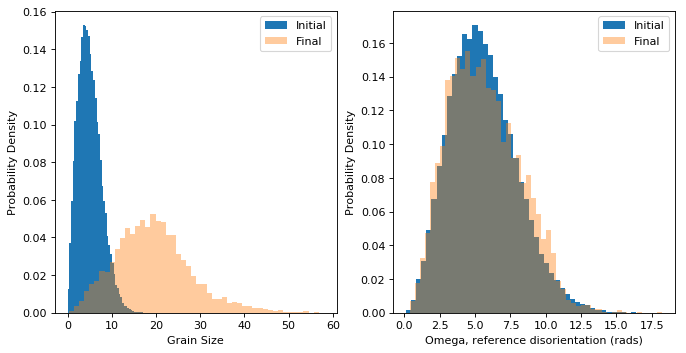

In [36]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(1,2,1)
v =ax.hist(Ri,bins=50,density=True,alpha=1.0,label='Initial')
v =ax.hist(Rj,bins=50,density=True,alpha=0.4,label='Final')
plt.xlabel('Grain Size')
plt.ylabel('Probability Density')
ax.legend()

ax2 = fig.add_subplot(1,2,2)
v=ax2.hist(omega*180/numpy.pi,bins=50,density=True,alpha=1.0,label='Initial')
v=ax2.hist(omegaj*180/numpy.pi,bins=50,density=True,alpha=0.4,label='Final')
plt.xlabel('Omega, reference disorientation (rads)')
plt.ylabel('Probability Density')
ax2.legend()

print('Comparing Grain Size and Disorientation Distributions before and after simulation')

Text(0,0.5,'Mean Grain Size, $\\bar{R_i}$')

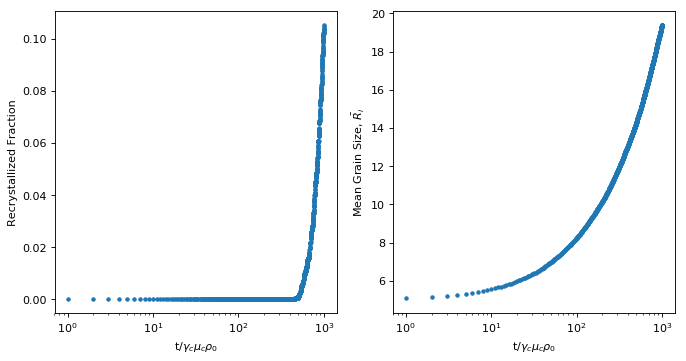

In [37]:
t = numpy.linspace(0,Nsteps*dt,Nsteps) # Time in units of $gamma_c*mu_c*rho_0  where rho_0 is the initial number of grains/area

fig2=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

ax3 = fig2.add_subplot(1,2,1)
ax3.semilogx(t,X,'.')
plt.xlabel('t/$\gamma_c \mu_c \\rho_0$')
plt.ylabel('Recrystallized Fraction')

ax4 = fig2.add_subplot(1,2,2)
ax4.semilogx(t,meanRi,'.')
plt.xlabel('t/$\gamma_c \mu_c \\rho_0$')
plt.ylabel('Mean Grain Size, $\\bar{R_i}$')